In [2]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [3]:
df_ba = pd.read_excel('/Users/enrico/Downloads/Carbonate_measurements2.xlsx', sheet_name='BaCO3 measurements')

df_hr = pd.read_excel('/Users/enrico/Downloads/Carbonate_measurements2.xlsx', sheet_name='Hard rock measurements')



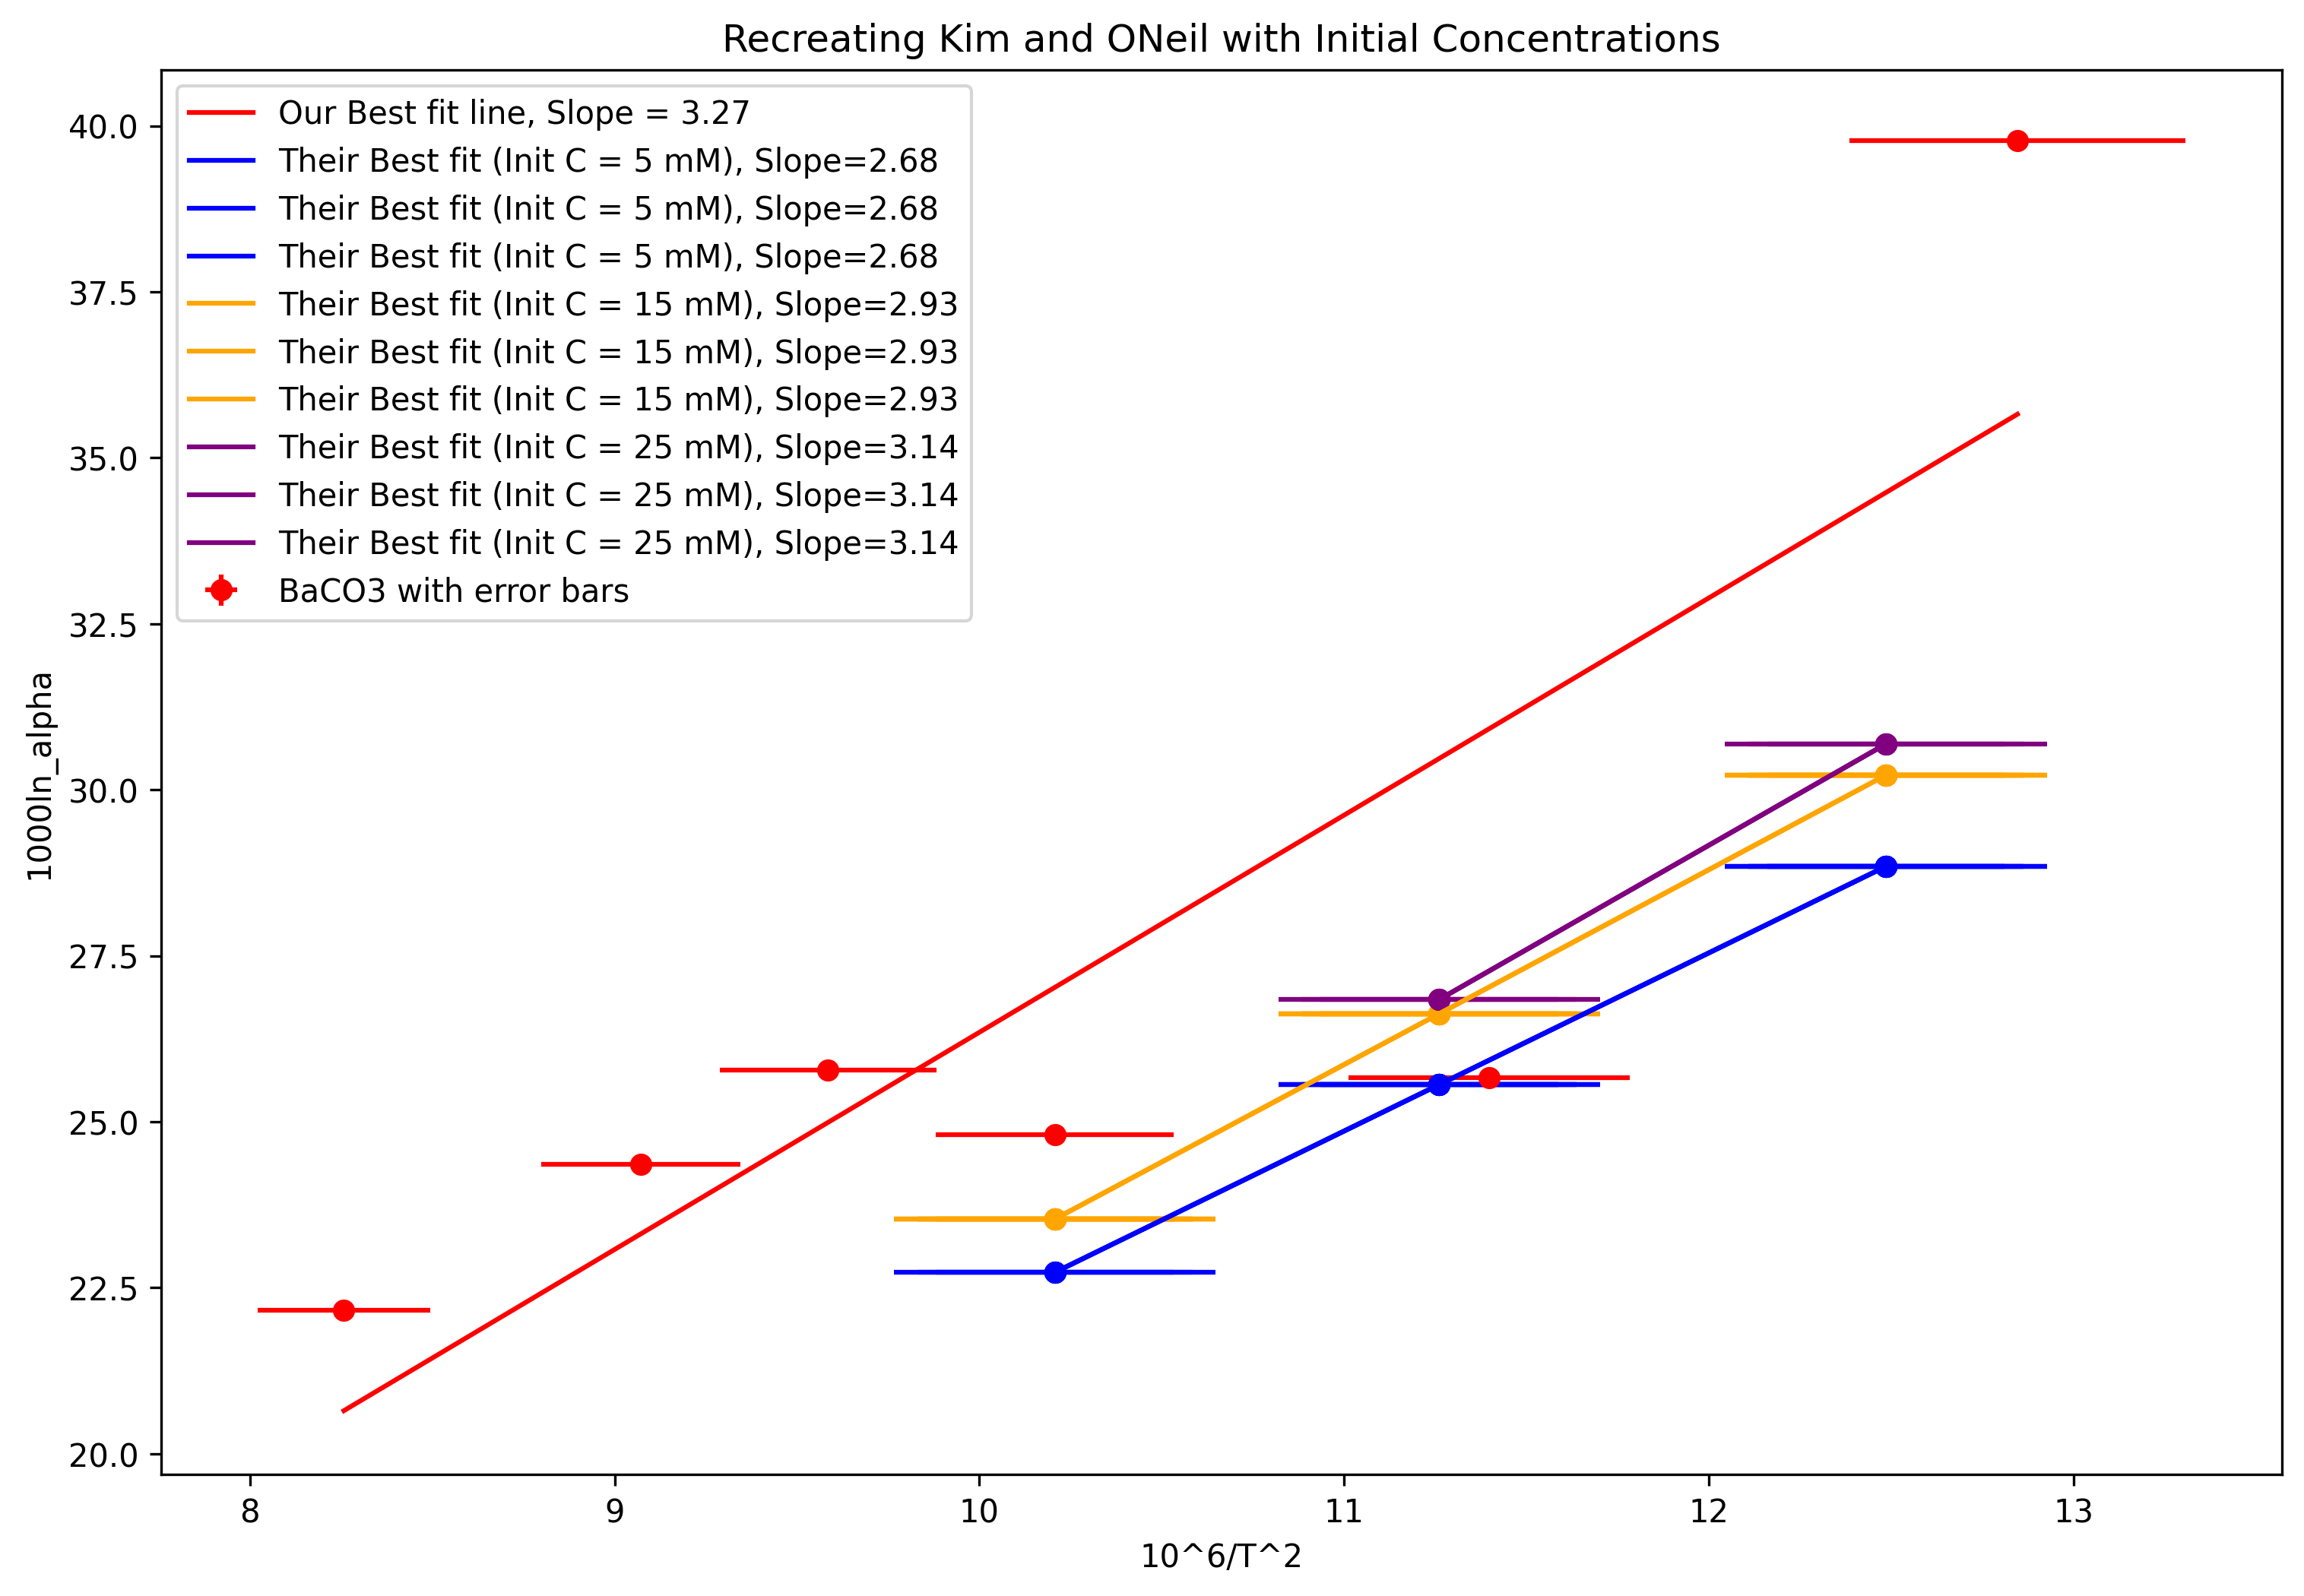

In [4]:
# create a new dataframe with x and y values
# x has valyes of 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 40, 40 ,40, 40
# y has valyes of 30.69, 30.19, 30.26, 30.09, 28.71, 28.92, 26.84, 26.94, 26.70, 26.50, 25.70, 25.55, 23.47, 23.53, 23.46, 22.66
t_kim = np.array([10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 40, 40 ,40, 40])
ln_kim = np.array([30.69, 30.19, 30.26, 30.09, 28.71, 28.92, 26.84, 26.94, 26.70, 26.50, 25.70, 25.55, 23.47, 23.53, 23.46, 22.66])
init_c_kim = np.array([25,15,15,15,5,5,25,15,15,15,5,5,15,15,15,5])

df_kim = pd.DataFrame({'Temperature': t_kim, '1000ln_alpha': ln_kim})

df_kim['10^6/T^2'] = 10**6/((df_kim['Temperature'] + 273)**2)

# Add initial concentrations to df_kim
df_kim['init_c_kim'] = init_c_kim

d180_water = -7.56 # SMOW

# plot Temperature against carbonate ox - water ox

# df_ba['Carbonate_ox'] = df_ba['           d18O VPDB']

# # Convert carbonate ox to SMOW
# df_ba['Carbonate_ox'] = df_ba['Carbonate_ox']*1.03092 + 30.92

# df_ba['Carbonate ox - water ox'] = df_ba['Carbonate_ox'] - d180_water

# df_ba carbonate ox - water ox is the same as d18Oc - d18Ow in this scenario




import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

d180_water = -7.56  # SMOW

# Convert carbonate ox to SMOW
# df_ba['Carbonate_ox'] = df_ba['d18O VPDB'] * 1.03092 + 30.92
# df_ba['1000ln_alpha'] = df_ba['Carbonate_ox'] - d180_water
# df_ba['10^6/T^2'] = 10**6 / ((df_ba['Temperature'] + 273) ** 2)


df_ba['1000ln_alpha'] = df_ba['d18Oc - d18Ow']

df_ba['10^6/T^2'] = 10**6/((df_ba['Temperature'] + 273)**2)


# Remove rows with NaN in either x or y
mask = ~np.isnan(df_ba['10^6/T^2']) & ~np.isnan(df_ba['1000ln_alpha'])
y = df_ba.loc[mask, '1000ln_alpha']
x = df_ba.loc[mask, '10^6/T^2']

# Add constant for intercept
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
slope1 = model.params['10^6/T^2']

# Define x and y axis uncertainties
#x_err = ????
y_err = 0.06  # ±0.06 for y-axis

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi = 300)

# Compute x-axis uncertainty for df_ba
df_ba['x_err'] = (2 * 10**6 / ((df_ba['Temperature'] + 273) ** 3)) * 5  # Propagation formula

# Compute x-axis uncertainty for df_kim
df_kim['x_err'] = (2 * 10**6 / ((df_kim['Temperature'] + 273) ** 3)) * 5  # Propagation formula

# Now assign them properly in the error bars
ax.errorbar(
    df_ba['10^6/T^2'], df_ba['1000ln_alpha'], 
    xerr=df_ba['x_err'], yerr=0.1, fmt='o', color='red', label='BaCO3 with error bars'
)



# Best-fit line
ax.plot(x['10^6/T^2'], predictions, color='red', label=f'Our Best fit line, Slope = {slope1:.2f}')
#ax.plot(x['10^6/T^2'], predictions - 4.5, color='red', linestyle="--", label='Our best fit line - 4.5')




uncertainty = {
    10: 0.4412052722088726,
    25: 0.37787765168084514,
    40: 0.3261121557751675}



# # Plot Kim & O'Neil data
# ax.errorbar(
#     df_kim['10^6/T^2'], df_kim['1000ln_alpha'],
#     #xerr= ?????,
#     yerr=0.06, fmt='o', color='green', label='BaCO3 - THEIR EXP'
# )

# Define colors for groups
colors = {5: 'blue', 15: 'orange', 25: 'purple'}



# Loop through concentrations and fit models
for concentration in [5, 15, 25]:
    for temperature in [10, 25, 40]:
        group = df_kim[df_kim['init_c_kim'] == concentration]
        x_group = group['10^6/T^2']
        y_group = group['1000ln_alpha']
        
        x_group = sm.add_constant(x_group)
        model = sm.OLS(y_group, x_group).fit()
        predictions = model.predict(x_group)
        slope = model.params['10^6/T^2']
        ax.plot(group['10^6/T^2'], predictions, color=colors[concentration], label=f'Their Best fit (Init C = {concentration} mM), Slope={slope:.2f}', zorder = 5)
        ax.errorbar(
        group['10^6/T^2'], predictions,
            xerr=uncertainty[temperature], yerr=0.1, fmt='o', color=colors[concentration]
        )

# Labels and legend
ax.set_ylabel('1000ln_alpha')
ax.set_xlabel('10^6/T^2')
ax.set_title('Recreating Kim and ONeil with Initial Concentrations')
ax.legend()
plt.savefig('Kim_and_ONeil.svg')
plt.show()



# alpha look at Coplen - cannot be that high, eqm?



# alpha look at Coplen - cannot be that high, eqm?

/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


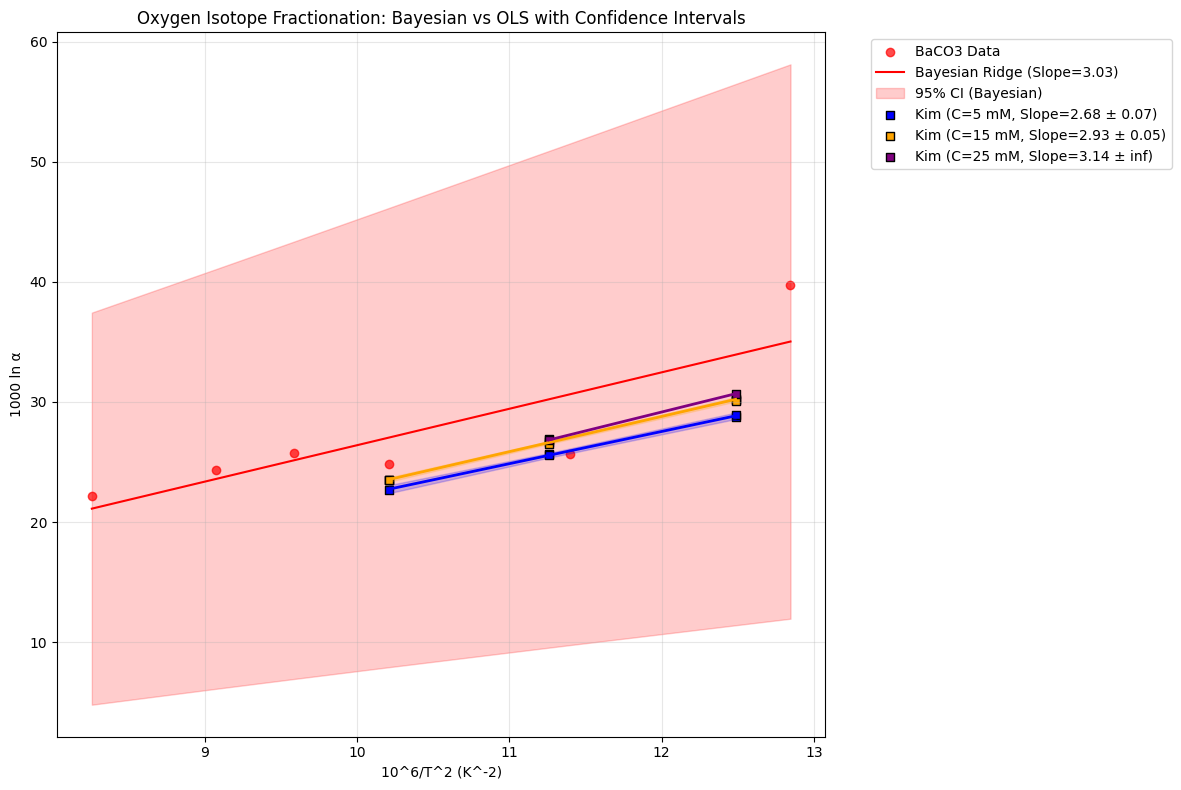

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import BayesianRidge


#1000 ln alpha = delta18Oc - delta18Ow just fyi, that's why it's like that in the excel doc

# Prepare data for Bayesian Ridge Regression
mask = df_ba[['10^6/T^2', '1000ln_alpha']].notnull().all(axis=1)
X_ba = sm.add_constant(df_ba.loc[mask, '10^6/T^2'])
y_ba = df_ba.loc[mask, '1000ln_alpha']

# Fit Bayesian Ridge model
bayesian_ridge = BayesianRidge(compute_score=True)
bayesian_ridge.fit(X_ba, y_ba)
y_pred_ba, y_std_ba = bayesian_ridge.predict(X_ba, return_std=True)

# Create Kim's dataset
df_kim = pd.DataFrame({
    'Temperature': [10]*6 + [25]*6 + [40]*4,
    '1000ln_alpha': [30.69,30.19,30.26,30.09,28.71,28.92,26.84,26.94,26.70,
                     26.50,25.70,25.55,23.47,23.53,23.46,22.66],
    'init_c_kim': [25,15,15,15,5,5,25,15,15,15,5,5,15,15,15,5]
})
df_kim['10^6/T^2'] = 10**6 / ((df_kim['Temperature'] + 273)**2)

# Plot configuration
plt.figure(figsize=(12, 8))
colors = {5: 'blue', 15: 'orange', 25: 'purple'}

# Plot Bayesian Ridge results
plt.scatter(X_ba['10^6/T^2'], y_ba, color='red', alpha=0.7, label='BaCO3 Data')
plt.plot(X_ba['10^6/T^2'], y_pred_ba, 'r-', 
         label=f'Bayesian Ridge (Slope={bayesian_ridge.coef_[1]:.2f})')
plt.fill_between(X_ba['10^6/T^2'], 
                 y_pred_ba - 1.96*y_std_ba,
                 y_pred_ba + 1.96*y_std_ba,
                 color='red', alpha=0.2, label='95% CI (Bayesian)')

# Plot and fit Kim's data
for concentration, color in colors.items():
    subset = df_kim[df_kim['init_c_kim'] == concentration]
    X_kim = sm.add_constant(subset['10^6/T^2'])
    y_kim = subset['1000ln_alpha']
    
    # Fit OLS model
    ols_model = sm.OLS(y_kim, X_kim).fit()
    predictions = ols_model.get_prediction(X_kim)
    pred_summary = predictions.summary_frame(alpha=0.05)
    
    # Plot results
    label = (f'Kim (C={concentration} mM, '
             f'Slope={ols_model.params[1]:.2f} ± '
             f"{ols_model.bse[1]:.2f})")
    plt.scatter(subset['10^6/T^2'], y_kim, color=color, 
                marker='s', edgecolor='k', label=label)
    plt.plot(subset['10^6/T^2'], pred_summary['mean'], color=color, linewidth=2)
    plt.fill_between(subset['10^6/T^2'], 
                     pred_summary['mean_ci_lower'],
                     pred_summary['mean_ci_upper'],
                     color=color, alpha=0.2)

plt.xlabel('10^6/T^2 (K^-2)')
plt.ylabel('1000 ln α')
plt.title('Oxygen Isotope Fractionation: Bayesian vs OLS with Confidence Intervals')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# kinetic effects
# difference could be in precipitation rate in terms of how they ppt BaCO3 -> need to look at their paper
# slowly infuse through a membrane


# or
# reaction is exothermic
# at a higher temperature than what we measured it to be



# Difference cannot be due to different initial concentrations
# Our concentration was 10mM. That should plot between the yellow line and the blue line

/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


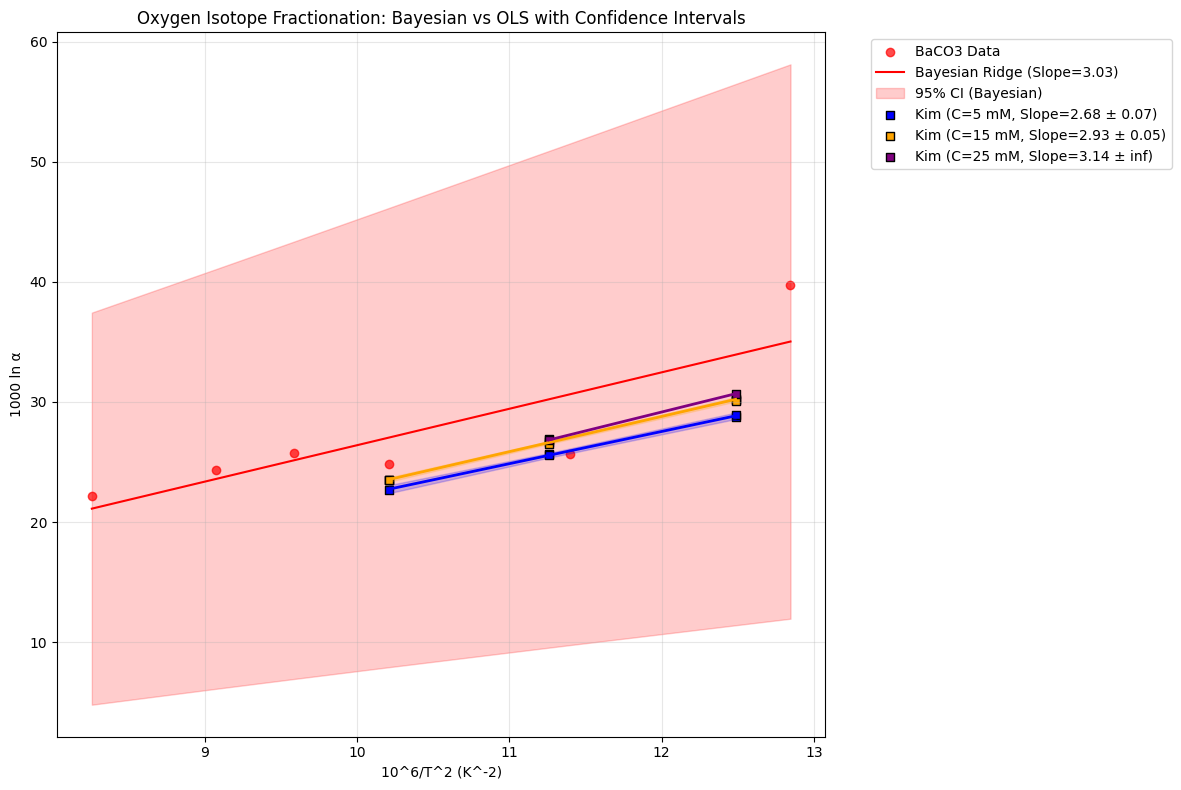

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import BayesianRidge


#1000 ln alpha = delta18Oc - delta18Ow just fyi, that's why it's like that in the excel doc

# Prepare data for Bayesian Ridge Regression
mask = df_ba[['10^6/T^2', '1000ln_alpha']].notnull().all(axis=1)
X_ba = sm.add_constant(df_ba.loc[mask, '10^6/T^2'])
y_ba = df_ba.loc[mask, '1000ln_alpha']

# Fit Bayesian Ridge model
bayesian_ridge = BayesianRidge(compute_score=True)
bayesian_ridge.fit(X_ba, y_ba)
y_pred_ba, y_std_ba = bayesian_ridge.predict(X_ba, return_std=True)

# Create Kim's dataset
df_kim = pd.DataFrame({
    'Temperature': [10]*6 + [25]*6 + [40]*4,
    '1000ln_alpha': [30.69,30.19,30.26,30.09,28.71,28.92,26.84,26.94,26.70,
                     26.50,25.70,25.55,23.47,23.53,23.46,22.66],
    'init_c_kim': [25,15,15,15,5,5,25,15,15,15,5,5,15,15,15,5]
})
df_kim['10^6/T^2'] = 10**6 / ((df_kim['Temperature'] + 273)**2)

# Plot configuration
plt.figure(figsize=(12, 8))
colors = {5: 'blue', 15: 'orange', 25: 'purple'}

# Plot Bayesian Ridge results
plt.scatter(X_ba['10^6/T^2'], y_ba, color='red', alpha=0.7, label='BaCO3 Data')
plt.plot(X_ba['10^6/T^2'], y_pred_ba, 'r-', 
         label=f'Bayesian Ridge (Slope={bayesian_ridge.coef_[1]:.2f})')
plt.fill_between(X_ba['10^6/T^2'], 
                 y_pred_ba - 1.96*y_std_ba,
                 y_pred_ba + 1.96*y_std_ba,
                 color='red', alpha=0.2, label='95% CI (Bayesian)')

# Plot and fit Kim's data
for concentration, color in colors.items():
    subset = df_kim[df_kim['init_c_kim'] == concentration]
    X_kim = sm.add_constant(subset['10^6/T^2'])
    y_kim = subset['1000ln_alpha']
    
    # Fit OLS model
    ols_model = sm.OLS(y_kim, X_kim).fit()
    predictions = ols_model.get_prediction(X_kim)
    pred_summary = predictions.summary_frame(alpha=0.05)
    
    # Plot results
    label = (f'Kim (C={concentration} mM, '
             f'Slope={ols_model.params[1]:.2f} ± '
             f"{ols_model.bse[1]:.2f})")
    plt.scatter(subset['10^6/T^2'], y_kim, color=color, 
                marker='s', edgecolor='k', label=label)
    plt.plot(subset['10^6/T^2'], pred_summary['mean'], color=color, linewidth=2)
    plt.fill_between(subset['10^6/T^2'], 
                     pred_summary['mean_ci_lower'],
                     pred_summary['mean_ci_upper'],
                     color=color, alpha=0.2)

plt.xlabel('10^6/T^2 (K^-2)')
plt.ylabel('1000 ln α')
plt.title('Oxygen Isotope Fractionation: Bayesian vs OLS with Confidence Intervals')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

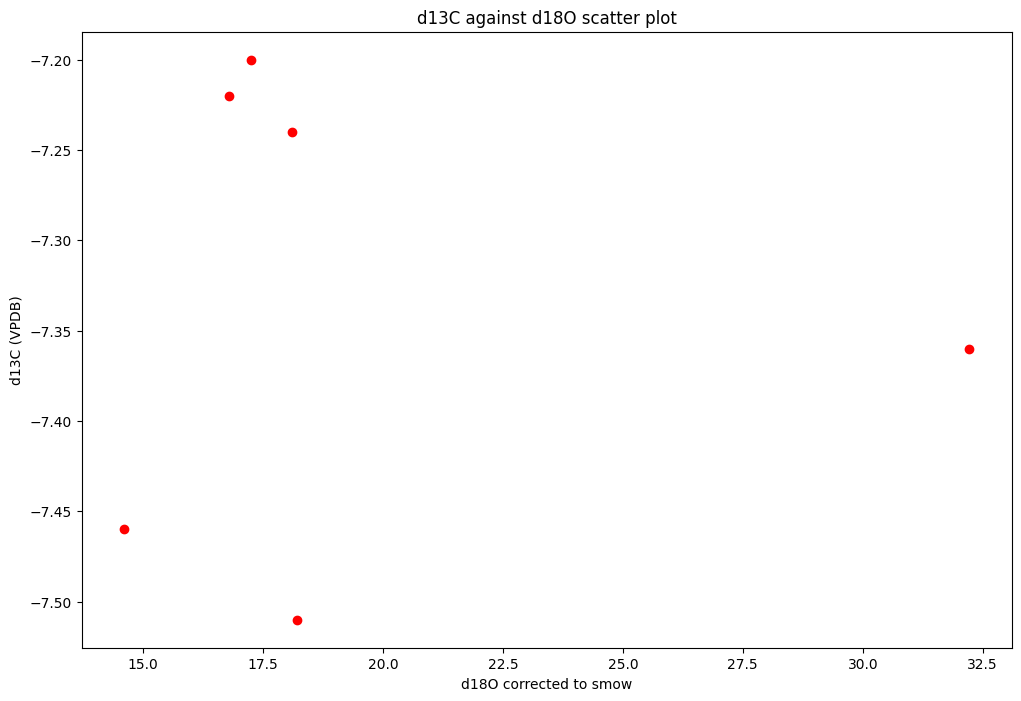

In [8]:
df_ba['d18O_SMOW'] = df_ba['d18O corrected to smow']

df_ba['d13C_VPDB'] = df_ba['d13C (VPDB)']

# plot d13C against d18O scatter plot

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.scatter(df_ba['d18O corrected to smow'], df_ba['d13C (VPDB)'], color='red', label='BaCO3')

ax.set_ylabel('d13C (VPDB)')
ax.set_xlabel('d18O corrected to smow')

ax.set_title('d13C against d18O scatter plot')

plt.show()

In [10]:
df_sannah = pd.read_excel('/Users/enrico/Downloads/Carbonate measurements.xlsx', sheet_name='Hard rock temps')

df_carb = pd.read_excel('/Users/enrico/Downloads/Carbonate measurements.xlsx', sheet_name='Hard rock')

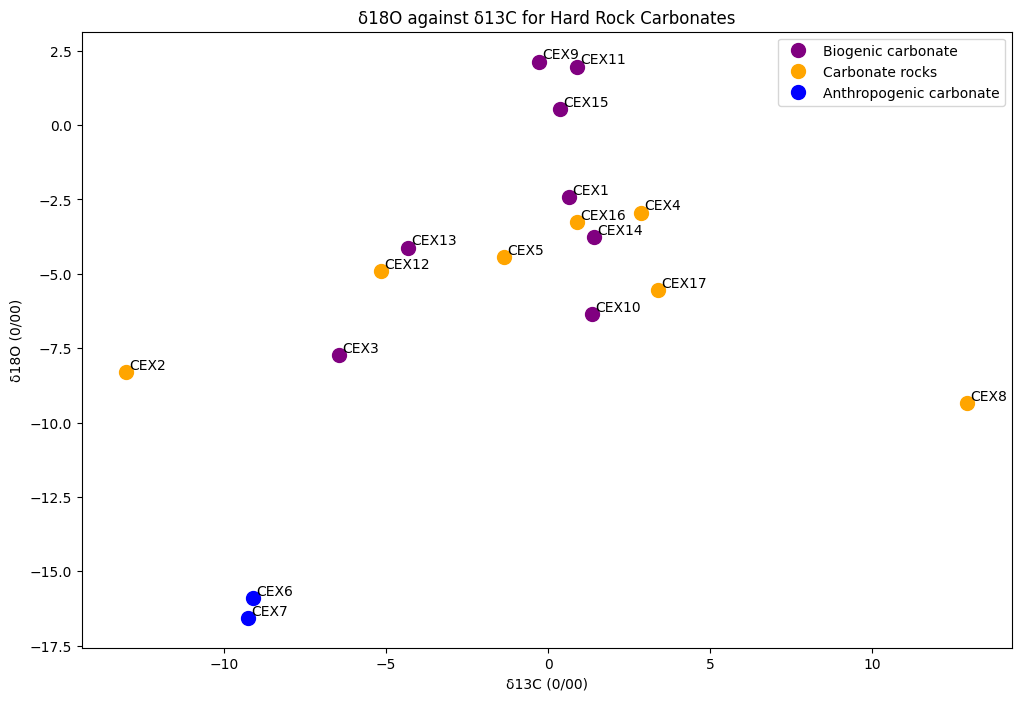

In [24]:
# plot d13C against d18O scatter plot for df_carb

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

categories = df_carb['Sample cat'].unique()
colors = ['purple', 'orange', 'blue']
category_colors = dict(zip(categories, colors))

for category, color in category_colors.items():
    subset = df_carb[df_carb['Sample cat'] == category]
    ax.errorbar(subset['d13C'], subset['d18O'], xerr=0.06, yerr=0.06, fmt='o', color=color, label=category, markersize=10)

ax.legend()

for i, txt in enumerate(df_carb['Sample#']):
    ax.annotate(txt, (df_carb['d13C'][i] + 0.1, df_carb['d18O'][i] + 0.1))

ax.set_xlabel('δ13C (0/00)')
ax.set_ylabel('δ18O (0/00)')
ax.set_title('δ18O against δ13C for Hard Rock Carbonates')

plt.savefig('d18O_against_d13C_Hard_Rock.pdf')

plt.show()


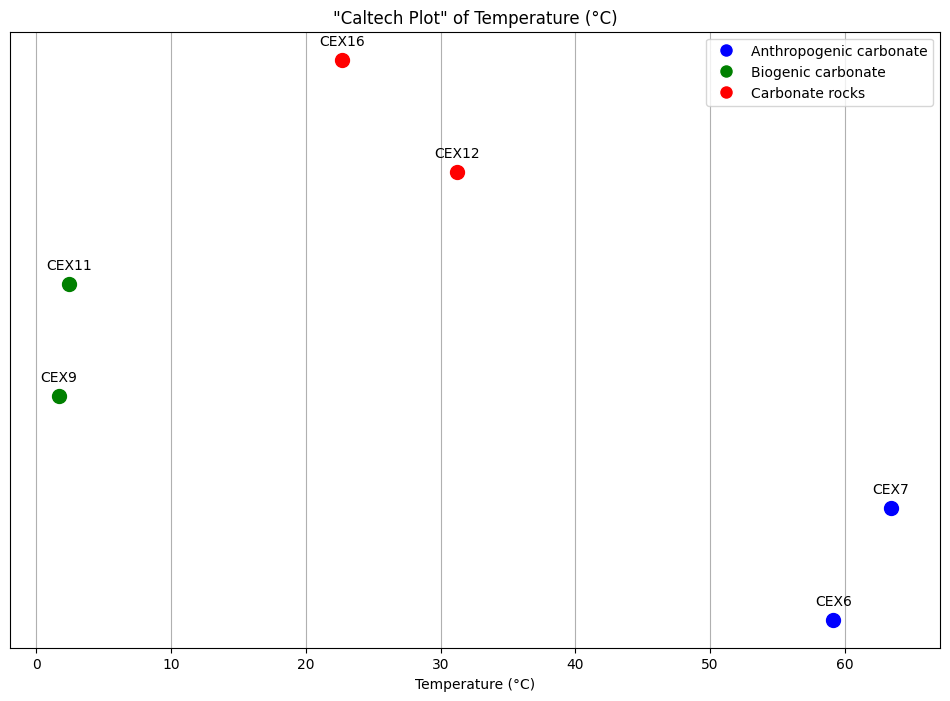

In [36]:
import matplotlib.pyplot as plt

# Given data
data = {
    'Sample#': ['CEX6', 'CEX7', 'CEX9', 'CEX11', 'CEX12', 'CEX16'],
    'Sample type': ['Kettle precipitate', 'Kettle precipitate', 'Limpet', 'Gastropod', 'Carbonate', 'Carbonate'],
    'Sample cat': ['Anthropogenic carbonate', 'Anthropogenic carbonate', 'Biogenic carbonate', 'Biogenic carbonate', 'Carbonate rocks', 'Carbonate rocks'],
    'del18O carb (VSMOW)': [14.53, 13.84, 33.13, 32.95, 25.85, 27.56],
    'del18O water': [-7.34, -7.34, -0.09, -0.09, -1.00, -1.00],
    'T/C': [59.14, 63.42, 1.68, 2.42, 31.21, 22.67]
}

# Create a DataFrame
df_caltech = pd.DataFrame(data)

# Plot configuration
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for categories
category_colors = {
    'Anthropogenic carbonate': 'blue',
    'Biogenic carbonate': 'green',
    'Carbonate rocks': 'red'
}
# Sort the DataFrame by temperature
df_caltech_sorted = df_caltech.sort_values(by='T/C')
# Plot data points
for i, row in df_caltech_sorted.iterrows():
    ax.scatter(row['T/C'], i, color=category_colors[row['Sample cat']], s=100)
    ax.annotate(row['Sample#'], (row['T/C'], i), textcoords="offset points", xytext=(0,10), ha='center')
    ax.errorbar(row['T/C'], i, xerr=0.5, fmt='o', color=category_colors[row['Sample cat']])

# Labels and title
ax.set_xlabel('Temperature (°C)')
ax.set_title('"Caltech Plot" of Temperature (°C)')
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat) for cat, color in category_colors.items()])
plt.grid(True)
ax.get_yaxis().set_visible(False)

plt.savefig('Caltech_Plot.pdf')
plt.show()

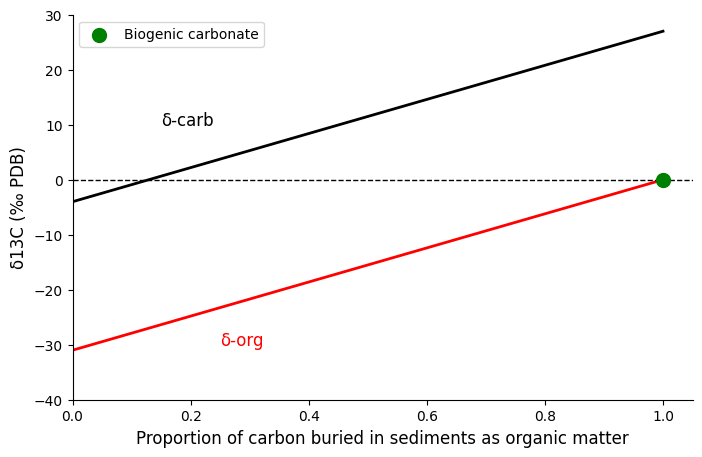

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
x = np.linspace(0, 1, 100)
organic = -31 + 31 * x  # Line passing through (0, -31) and (1, 0)
calcite = organic + 27  # Offset by +27 on the y-axis

# Today's proportion
x_today = 0.2
y_calcite_today = calcite[int(x_today * 100)]
y_organic_today = organic[int(x_today * 100)]

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, calcite, color='black', linewidth=2)
ax.plot(x, organic, color='red', linewidth=2)

# Add vertical dashed line
#ax.axvline(x_today, linestyle='dashed', color='black', linewidth=2)

# Add circles at intersections
#ax.scatter([x_today], [y_calcite_today], facecolors='white', edgecolors='black', s=100)
#ax.scatter([x_today], [y_organic_today], facecolors='white', edgecolors='black', s=100)

# Labels
ax.set_xlabel("Proportion of carbon buried in sediments as organic matter", fontsize=12)
ax.set_ylabel("δ13C (‰ PDB)", fontsize=12)
ax.text(0.15, 10, "δ-carb", fontsize=12)
ax.text(0.25, -30, "δ-org", fontsize=12, color='red')
# Add horizontal dashed line at y=0
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Add a filled circle at the end
ax.scatter([1], [organic[-1]], facecolors='green', edgecolors='green', zorder = 5, s=100, label='Biogenic carbonate')
# Formatting
ax.set_xlim(0, 1.05)
ax.set_ylim(-40, 30)

ax.legend() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('box_model.pdf')

plt.show()
